<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reading-Data" data-toc-modified-id="Reading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Train-Test-split" data-toc-modified-id="Train-Test-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test split</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Cross Validation</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

pd.set_option("max_colwidth", -1)
pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)

from tqdm.notebook import tqdm as tqdm

plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data_dir = '../'
data_folder = f'{data_dir}/Scripts/'

### Reading Data

In [3]:
target = 'Labels'

In [4]:
train_df = pd.read_csv(data_dir+'Train.csv')
train_df.head()

,File_Name,Labels
0,file_2180.txt,8
1,file_693.txt,4
2,file_2469.txt,6
3,file_2542.txt,6
4,file_378.txt,16


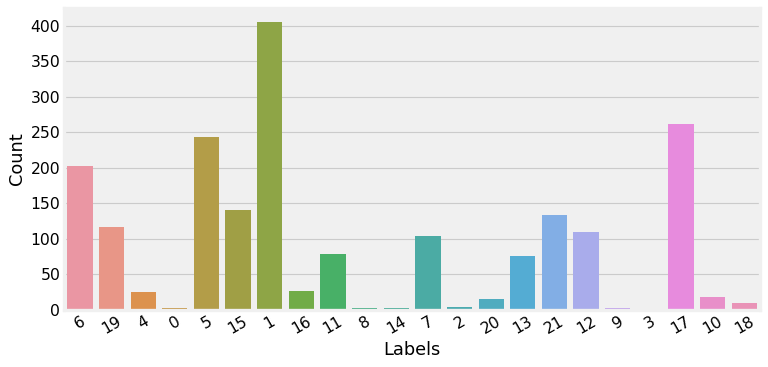

In [5]:
import seaborn as sns
# Set up graph
fig, ax = plt.subplots(1, 1, dpi = 80, figsize = (10, 5))

# Get data
labels = train_df[target].value_counts().index
count = train_df[target].value_counts()

# Plot graph
sns.barplot(x = labels, y = count)

# Plot labels
ax.set_ylabel('Count')    
ax.set_xlabel(f'{target}')
ax.set_xticklabels(labels , rotation=30)
plt.show()

In [6]:
test_df = pd.read_csv(data_dir+'Test.csv')
test_df.head()

,File_Name
0,file_2300.txt
1,file_809.txt
2,file_1383.txt
3,file_983.txt
4,file_1713.txt


In [7]:
train_df['Script'] = [open(data_folder + os.sep + file, "r").read() for file in train_df['File_Name']]
test_df['Script'] = [open(data_folder + os.sep + file, "r").read() for file in test_df['File_Name']]

In [8]:
#duplicating the row for stratification in case of labels with less than 5 records

label_count = train_df.Labels.value_counts()

lesser_records_labels = label_count[label_count<5].index
for label in lesser_records_labels:
    total_new_records = 5 - (train_df['Labels'] == label).sum()
    for i in range(total_new_records):
        train_df = train_df.append(train_df[train_df['Labels'] == label].sample(n=1, random_state=242424*(i+1)))
train_df.reset_index(drop=True, inplace=True)

### EDA

In [9]:
train_df['Script_len'] = train_df['Script'].map(len)
train_df['Script_num_words'] = train_df['Script'].apply(lambda x: len(x.split()))

test_df['Script_len'] = test_df['Script'].map(len)
test_df['Script_num_words'] = test_df['Script'].apply(lambda x: len(x.split()))

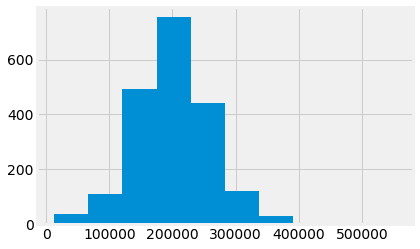

In [10]:
plt.hist(train_df['Script_len'])
plt.show()

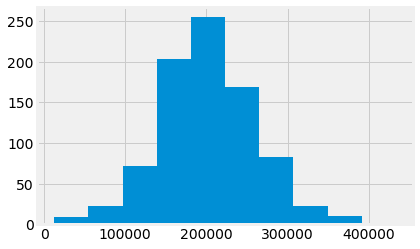

In [11]:
plt.hist(test_df['Script_len'])
plt.show()

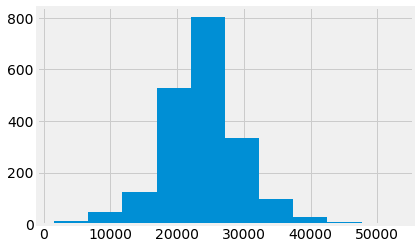

In [12]:
plt.hist(train_df['Script_num_words'])
plt.show()

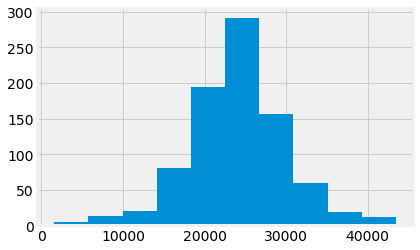

In [13]:
plt.hist(test_df['Script_num_words'])
plt.show()

In [14]:
# Saving Labels sequence in a separate dictionary to avoid confusions. 
# This mapping will be used later to properly order the columns before submission

label_dict = {}
label_dict_rev = {}
for i, label in enumerate(train_df.Labels.unique()):
    label_dict[label] = i
    label_dict_rev[i] = label
y = train_df.Labels.map(label_dict)

### Train Test split

In [15]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.Script.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.30, shuffle=True)

In [16]:
print (xtrain.shape)
print (xvalid.shape)

(1395,)
(599,)


### Feature Engineering

In [17]:
%%time
tfv = TfidfVectorizer(min_df=50,  max_features=5000, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
x_test_tfv = tfv.transform(test_df['Script'].values)

CPU times: user 3min 48s, sys: 3.68 s, total: 3min 51s
Wall time: 3min 52s


### Training

In [18]:
from sklearn.linear_model import LogisticRegressionCV
## Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegressionCV(max_iter=1000)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print("logloss: %0.3f " % log_loss(yvalid, predictions))

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


logloss: 2.287 


### Cross Validation

In [19]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

kf = StratifiedKFold(n_splits=3)
score = cross_val_score(clf, xtrain_tfv, ytrain, cv=kf, scoring='neg_log_loss', n_jobs=-1)
score.mean()

-2.3132793753180256

### Prediction

In [20]:
test_set_preds = pd.DataFrame(columns=clf.classes_, 
                              data=clf.predict_proba(x_test_tfv))
test_set_preds = test_set_preds.rename(columns=label_dict_rev)
test_set_preds['File_Name'] = test_df['File_Name']

test_set_preds = test_set_preds[['File_Name',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]

In [21]:
test_set_preds.to_excel('baseline.xlsx', index=False)